# Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


c:\programdata\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Define parameters for image loading here:

In [3]:
# Common parameters for loading the image files of interest

# for 4 channels image: channel index as 1-2-3-4 as the order for ch405-ch488-ch560-ch647
# Replace protein/dna name in the "xxx" below for the indicated channel index
num_of_ch = 4

# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
ch_dict = {"dna":1,"53BP1SC":2,"mdc1":3,"pol2S5":4}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"
data_save_folder = r"E:\Data_Stam\210228IF_210225exp_Mdc1_Fixed\cov1_53BP1SC\*"


#  Load all image files

In [4]:

# read data files from the hard drive
data_folder = data_save_folder
data_files = [file for file in glob.glob(data_folder) if file[-3:]=="TIF" and "thumb" not in file]

# group images for the same fov
sorted_data_files = []
num_of_ch = num_of_ch
num_of_img = len(data_files)
if num_of_img%num_of_ch == 0: #check if all images contain the same number of channels
    for i in range (int(num_of_img/num_of_ch)):
        data_for_each_cell = data_files[i*num_of_ch:i*num_of_ch+4]
        sorted_data_files.append(data_for_each_cell)
        
num_of_fov =len(sorted_data_files)
print (f"There are {num_of_fov} fovs for this {num_of_ch}-channel image dataset.")

There are 57 fovs for this 4-channel image dataset.


60

3162.3333333333335

# Load fov of interest to check images and peform nucleus segmentation

In [5]:
# If use mdc1 for segementation
factor_key =  "mdc1"


pol2_key = "pol2S5"
# The pixel size for excluding small 53BP_foci;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 foci exclusion
small_53BP_size = 0



In [6]:

# Generate an empty list to store all measurements
measurement_for_all_fov = []

#To analyze a subset of fovs, use the code below where *2* means fov_0-fov_1; to analyze all fovs, replace *2* with num_of_fov;
# the number needs to be <= num_of_fov

for _fov_id in range (num_of_fov):
        
    # load images for 4 channels for each fov
    img_1 = io.imread(sorted_data_files[_fov_id][0])  #ch405 
    img_2 = io.imread(sorted_data_files[_fov_id][1])  #ch488
    img_3 = io.imread(sorted_data_files[_fov_id][2])  #ch560
    img_4 = io.imread(sorted_data_files[_fov_id][3])  #ch642
    # Store images into an img_dict based on their channel index
    ch_img_dict={'1':img_1,'2':img_2,'3':img_3,'4':img_4}
    # Find the best focal plane using the mdc1 channel
    image_fl = []
    image_std = []
    for i in range(len(ch_img_dict[str(ch_dict[factor_key])])):
        _fl = np.array(ch_img_dict[str(ch_dict[factor_key])][i,:,:].flatten())
        image_fl.append(_fl)
        image_std.append(np.std(_fl))
    best_plane_index = np.argmax(np.array(image_std))
    print(f"Analyzing the plane {best_plane_index} for the image {_fov_id} in this dataset")   
    
    # load the best focal plane
    img_1_bf=img_1[best_plane_index,:,:]
    img_2_bf=img_2[best_plane_index,:,:]
    img_3_bf=img_3[best_plane_index,:,:]
    img_4_bf=img_4[best_plane_index,:,:]
    # Update the img_dict
    ch_img_dict={'1':img_1_bf,'2':img_2_bf,'3':img_3_bf,'4':img_4_bf}
    
    
    # Use Li_global_th and binary operations to generate nuclei masks
    li_value =  threshold_li (ch_img_dict[str(ch_dict["dna"])])
    nuclei_mask = ch_img_dict[str(ch_dict["dna"])]>li_value
    erosion_factor_dna = 5
    eroded_nuclei_mask = erosion(nuclei_mask, disk(erosion_factor_dna))
    eroded_nuclei_mask = ndi.binary_fill_holes(eroded_nuclei_mask)
    eroded_nuclei_mask = remove_small_objects(eroded_nuclei_mask, 10000,connectivity=1)

    # erosion and dilation to remove micronuclei or small blebs
    eroded_nuclei_mask = erosion(eroded_nuclei_mask, disk(25))
    eroded_nuclei_mask = dilation(eroded_nuclei_mask, disk(25))
    # Nuclei segmentation to get all valid nuclei of interest
    labeled_nuclei, num_of_nuclei = ndi.label(eroded_nuclei_mask)

    # Add all valid nuclei to the list for downstream analysis
    kept_nuclei = []
    for i in range(num_of_nuclei):
        cand_nucleus = labeled_nuclei == i+1
        cand_nucleus[cand_nucleus>0]=1
        cand_nucleus = np.array(cand_nucleus)
        kept_nuclei.append(cand_nucleus)
       
    # Analyze each cell from this fov for all channels
    for cell_id in range(len(kept_nuclei)):
        # Generate masks for the MDC-labeled chromosome ("the reincorporated micronuclei") 
        # Q3 + 3* IQR (mdc1 intensity for the analyzed nucleus) used as the threshold for its segmentation
        nuclei_to_measure = kept_nuclei[cell_id]
        mdc_intensity = ch_img_dict[str(ch_dict["mdc1"])]*nuclei_to_measure
        mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
        mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*3
        #mdc_chr_mask = (ch_img_dict[str(ch_dict[factor_key])]>mdc_positive_th)*nuclei_to_measure
        mdc_chr_mask = (ch_img_dict[str(ch_dict["mdc1"])]>mdc_positive_th)*nuclei_to_measure
        
        # Removing small potential 53BP foci (change pixel size in the box above)
        mdc_chr_mask = remove_small_objects(mdc_chr_mask, small_53BP_size, connectivity=1)
        
        # Remove tiny unsure foci if no 53BP foci size exclusion were applied
        if small_53BP_size == 0:
            small_53BP_size = 100
        else:
            pass
        
        # Analyze valid mdc-labeled nuclear regions only
        if sum(mdc_chr_mask.flatten())>small_53BP_size:
            
            # Generate mask for the MDC-negative nucleous
            # lower 10% of the mdc1 intensity for the analyzed nucleus used to define the nucleolus 
            # newer segmentation using pol2 lower 10%
            pol2_intensity = ch_img_dict[str(ch_dict[pol2_key])]*nuclei_to_measure
            pol2_intensity_filtered = pol2_intensity[pol2_intensity!=0]
            pol2_negative_th = np.percentile(pol2_intensity_filtered,10)
            pol2_negative_mask = (ch_img_dict[str(ch_dict[pol2_key])]<pol2_negative_th)*nuclei_to_measure
            nucleolus_mask = remove_small_objects(pol2_negative_mask, 10,connectivity=1)      
            nucleolus_mask = dilation(nucleolus_mask, disk(3))
            
            
            # Generate mask for the rest chr in nuclei by removing the mdc-labeled and nucleolus regions
            ctrl_chr_mask1 = nuclei_to_measure *  (mdc_chr_mask == 0)
            ctrl_chr_mask2 = nuclei_to_measure * (nucleolus_mask ==0)
            ctrl_chr_mask = ctrl_chr_mask1*ctrl_chr_mask2
            # Generate mask for the non-cell/non-nuclei background
            noncell_background = erosion(nuclei_mask==0,disk(10))
            
            
            
            # Generate a subset of the rest chr as randomized contrl
            _random_index= np.random.choice(np.sum(ctrl_chr_mask), 1)
            _random_yx = [np.where(ctrl_chr_mask==1)[0][_random_index],
            np.where(ctrl_chr_mask==1)[1][_random_index]]
                        
            _seed_mask = np.zeros(ctrl_chr_mask.shape)
            _seed_mask [_random_yx[0][0],_random_yx[1][0]] = 1
                
            _expand_seed = True
            while _expand_seed:
                _seed_mask = dilation(_seed_mask, disk(3))
                #print (f'-- Generate seed mask for cell {_cell_id}')
                subset_ctrl_chr_mask = _seed_mask * (ctrl_chr_mask == 1) * (mdc_chr_mask == 0)
                if np.sum(subset_ctrl_chr_mask) >= np.sum(mdc_chr_mask): 
                    _expand_seed = False 
                    #print (f'-- Found control mask for cell {_cell_id}')
            _erode_seed = True
            while _erode_seed:
                if np.sum(subset_ctrl_chr_mask) >= np.sum(mdc_chr_mask) + 100:
                    subset_ctrl_chr_mask = erosion(subset_ctrl_chr_mask, disk(1))
                else:
                    _erode_seed = False
            
            
            # Save mask images in the source directory
            mask_save_path = data_save_folder[:-2] + os.sep + f'segmentations_{small_53BP_size}_subset_controlled' + os.sep + f'fov_{_fov_id}'
            if not os.path.exists(mask_save_path):
                os.makedirs(mask_save_path)
            mdc_chr_mask_savename = f'cell_{cell_id}_incoporated_chr.tif'
            ctrl_chr_mask_savename = f'cell_{cell_id}_control_chr_cell.tif'
            subset_ctrl_chr_mask_savename = f'cell_{cell_id}_subset_control_chr_cell.tif'
            io.imsave(mask_save_path+os.sep+mdc_chr_mask_savename,skimage.img_as_ubyte(mdc_chr_mask), check_contrast=False)
            io.imsave(mask_save_path+os.sep+ctrl_chr_mask_savename,skimage.img_as_ubyte(ctrl_chr_mask), check_contrast=False)
            io.imsave(mask_save_path+os.sep+subset_ctrl_chr_mask_savename,skimage.img_as_ubyte(subset_ctrl_chr_mask), 
                      check_contrast=False)
            
            
            # Generate an empty list to store measurement for each cells
            measurement_for_each_cell = []
            # Add fov_id and cell_id 
            measurement_for_each_cell.append (int(_fov_id))
            measurement_for_each_cell.append (int(cell_id))
            # Measure and add pixel area for MDC-labeled chromosome, control chromosomes, and nucleolus
            measurement_for_each_cell.append (np.sum(mdc_chr_mask))
            measurement_for_each_cell.append (np.sum(ctrl_chr_mask)) 
            measurement_for_each_cell.append (np.sum(subset_ctrl_chr_mask))  
            
            # Measure and add intensity for MDC-labeled chromosome, control chromosomes, and nucleolus for each channel
            for ch in range(num_of_ch):
                ch_to_measure = ch_img_dict[str(ch+1)]
                # Measure ave intensity
                mdc_chr_ave_intensity = (ch_to_measure * mdc_chr_mask)[(ch_to_measure * mdc_chr_mask)!=0].mean()
                ctrl_chr_ave_intensity = (ch_to_measure * ctrl_chr_mask)[(ch_to_measure * ctrl_chr_mask)!=0].mean()
                subset_ctrl_chr_ave_intensity = (ch_to_measure * subset_ctrl_chr_mask)[(ch_to_measure * subset_ctrl_chr_mask)!=0].mean()
                noncell_background_ave_intensity = (ch_to_measure*noncell_background)[(ch_to_measure*noncell_background)!=0].mean()
                # Background subtraction
                mdc_chr_ave_intensity = mdc_chr_ave_intensity - noncell_background_ave_intensity
                ctrl_chr_ave_intensity = ctrl_chr_ave_intensity - noncell_background_ave_intensity
                subset_ctrl_chr_ave_intensity = subset_ctrl_chr_ave_intensity - noncell_background_ave_intensity
                # Add measurements
                measurement_for_each_cell.append(mdc_chr_ave_intensity)
                measurement_for_each_cell.append(ctrl_chr_ave_intensity)
                measurement_for_each_cell.append(subset_ctrl_chr_ave_intensity)
                        
            # Add measurements for each cell to the measurements for all fovs
            measurement_for_each_cell = np.array(measurement_for_each_cell)
            measurement_for_all_fov.append(measurement_for_each_cell)
               

Analyzing the plane 3 for the image 0 in this dataset
Analyzing the plane 2 for the image 1 in this dataset
Analyzing the plane 1 for the image 2 in this dataset
Analyzing the plane 1 for the image 3 in this dataset
Analyzing the plane 1 for the image 4 in this dataset
Analyzing the plane 3 for the image 5 in this dataset
Analyzing the plane 2 for the image 6 in this dataset
Analyzing the plane 4 for the image 7 in this dataset
Analyzing the plane 3 for the image 8 in this dataset
Analyzing the plane 4 for the image 9 in this dataset
Analyzing the plane 2 for the image 10 in this dataset
Analyzing the plane 4 for the image 11 in this dataset
Analyzing the plane 4 for the image 12 in this dataset
Analyzing the plane 3 for the image 13 in this dataset
Analyzing the plane 3 for the image 14 in this dataset
Analyzing the plane 2 for the image 15 in this dataset
Analyzing the plane 2 for the image 16 in this dataset
Analyzing the plane 1 for the image 17 in this dataset
Analyzing the plane 

# Define channel information to save measurements as excel here:

In [7]:
# Replace the protein/dna name below as how they are ordered for the channel (ch405, ch488, ch560, ch647)
# For example, ch_save_list = ["dna","rpa2","mdc1","pol2S5"] if rpa2 in ch488

ch_save_list = ["dna","53BP1SC","Mdc1","Pol2S5"]

ch1 = ch_save_list[0]
ch2 = ch_save_list[1]
ch3 = ch_save_list[2]
ch4 = ch_save_list[3]

In [8]:
import pandas as pd

df = pd.DataFrame(measurement_for_all_fov)  
df.columns = ['fov_id','cell_id','area_incorporated_chr','area_nucleo-excluded_control_chr','area_subset_control_ctrl',
             f'ave_intensity_incorporated_chr_{ch1}',f'ave_intensity_nucleo-excluded_control_chr_{ch1}',f'ave_intensity_subset_control_chr_{ch1}',
             f'ave_intensity_incorporated_chr_{ch2}',f'ave_intensity_nucleo-excluded_control_chr_{ch2}',f'ave_intensity_subset_control_chr_{ch2}',
             f'ave_intensity_incorporated_chr_{ch3}',f'ave_intensity_nucleo-excluded_control_chr_{ch3}',f'ave_intensity_subset_control_chr_{ch3}',
             f'ave_intensity_incorporated_chr_{ch4}',f'ave_intensity_nucleo-excluded_control_chr_{ch4}',f'ave_intensity_subset_control_chr_{ch4}']

analysis_savename = f'measurement_for_all_fov_background_subtracted_{small_53BP_size}.xlsx'
analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis_subset_controlled'
if not os.path.exists(analysis_save_path):
    os.makedirs(analysis_save_path)
df.to_excel(analysis_save_path+os.sep+analysis_savename)


In [16]:
# remove the bad cell that has no Pol2 signal
#analysis_df=measurement_for_all_fov_df[measurement_for_all_fov_df['ave_intensity_control_chr_Pol2S5']>0].copy()
analysis_df =df.copy()

# for total incorporated chr
analysis_df['normalized_inc_Pol2S5']=analysis_df['ave_intensity_incorporated_chr_Pol2S5']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']
print(analysis_df['normalized_inc_Pol2S5'].mean())


# for subset control
analysis_df['normalized_subset_control_Pol2S5']=analysis_df['ave_intensity_subset_control_chr_Pol2S5']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Pol2S5']
print(analysis_df['normalized_subset_control_Pol2S5'].mean())



# get the h2ax-positive area vs h2ax-less (positive) area for the same cell
analysis_df['normalized_inc_53BP1SC'] = analysis_df['ave_intensity_incorporated_chr_53BP1SC']/analysis_df['ave_intensity_nucleo-excluded_control_chr_53BP1SC']
print(analysis_df['normalized_inc_53BP1SC'].mean())


# for subset control
analysis_df['normalized_subset_control_53BP1SC']=analysis_df['ave_intensity_subset_control_chr_53BP1SC']/analysis_df['ave_intensity_nucleo-excluded_control_chr_53BP1SC']
print(analysis_df['normalized_subset_control_53BP1SC'].mean())






# get the h2ax-positive area vs h2ax-less (positive) area for the same cell
analysis_df['normalized_inc_Mdc1'] = analysis_df['ave_intensity_incorporated_chr_Mdc1']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Mdc1']
print(analysis_df['normalized_inc_Mdc1'].mean())


# for subset control
analysis_df['normalized_subset_control_Mdc1']=analysis_df['ave_intensity_subset_control_chr_Mdc1']/analysis_df['ave_intensity_nucleo-excluded_control_chr_Mdc1']
print(analysis_df['normalized_subset_control_Mdc1'].mean())





# get the h2ax-positive area vs h2ax-less (positive) area for the same cell
analysis_df['normalized_inc_dna'] = analysis_df['ave_intensity_incorporated_chr_dna']/analysis_df['ave_intensity_nucleo-excluded_control_chr_dna']
print(analysis_df['normalized_inc_dna'].mean())


# for subset control
analysis_df['normalized_subset_control_dna']=analysis_df['ave_intensity_subset_control_chr_dna']/analysis_df['ave_intensity_nucleo-excluded_control_chr_dna']
print(analysis_df['normalized_subset_control_dna'].mean())

0.8510730078981107
0.9808166971866824
17.679071177978056
1.0021769541525252
4.493046909441153
1.059929755871838
1.0790845465667394
1.015600377004749


MW comparision: 0.03151855718906992


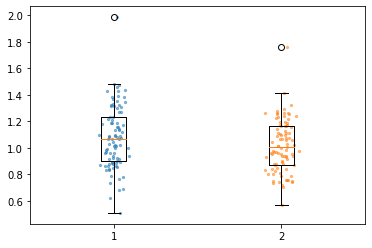

In [10]:
# for dna

# 
g1 = analysis_df['normalized_inc_dna']
g2 = analysis_df['normalized_subset_control_dna']
#g3 = no_damaged_chr_df['normalized_inc_Pol2S5']
#g4 = analysis_df['normalized_subset_control_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)

boxplot_pol2= plt.boxplot([g1,g2], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")

MW comparision: 2.3165585554985274e-30


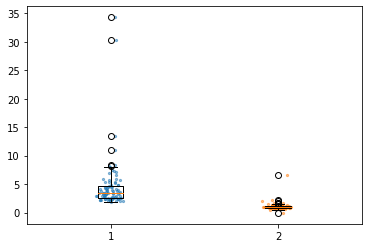

In [11]:
# for mdc1

analysis_df_filtered = analysis_df[analysis_df['normalized_inc_Mdc1'] > 0]
g1 = analysis_df_filtered['normalized_inc_Mdc1']
g2 = analysis_df_filtered['normalized_subset_control_Mdc1']
#g3 = no_damaged_chr_df['normalized_inc_Pol2S5']
#g4 = analysis_df['normalized_subset_control_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)

boxplot_pol2= plt.boxplot([g1,g2], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 4.1568448051014455e-05


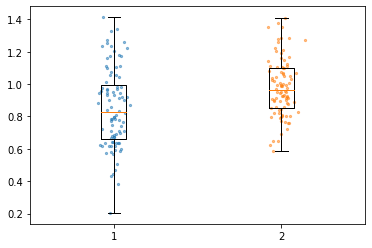

In [12]:
# For Pol2S5
g1 = analysis_df['normalized_inc_Pol2S5']
g2 = analysis_df['normalized_subset_control_Pol2S5']
#g3 = no_damaged_chr_df['normalized_inc_Pol2S5']
#g4 = analysis_df['normalized_subset_control_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)

boxplot_pol2= plt.boxplot([g1,g2], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 2.6856039216739234e-06


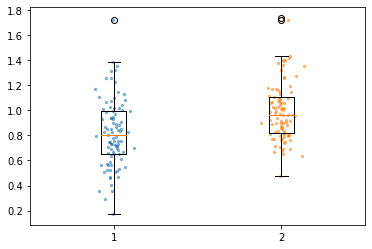

In [13]:
# For Pol2S5 norm to dna
g1 = analysis_df['normalized_inc_Pol2S5']/analysis_df['normalized_inc_dna']
g2 = analysis_df['normalized_subset_control_Pol2S5']/analysis_df['normalized_subset_control_dna']
#g3 = no_damaged_chr_df['normalized_inc_Pol2S5']
#g4 = analysis_df['normalized_subset_control_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)

boxplot_pol2= plt.boxplot([g1,g2], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 1.0604890903442014e-26


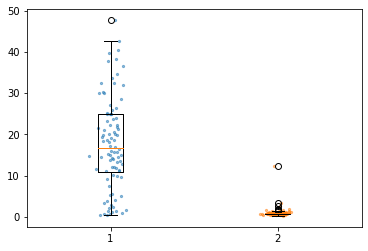

In [17]:
# For H2ax
g1 = analysis_df['normalized_inc_53BP1SC']
g2 = analysis_df['normalized_subset_control_53BP1SC']
#g3 = no_damaged_chr_df['normalized_inc_Pol2S5']
#g4 = analysis_df['normalized_subset_control_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)

boxplot_pol2= plt.boxplot([g1,g2], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([g1,g2]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 5, alpha=0.5)


from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)
from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



In [12]:
df

,fov_id,cell_id,area_incorporated_chr,area_control_chr,area_nucleolus,ave_intensity_incorporated_chr_dna,ave_intensity_control_chr_dna,ave_intensity_nucleolus_dna,ave_intensity_incorporated_chr_53BP1,ave_intensity_control_chr_53BP1,ave_intensity_nucleolus_53BP1,ave_intensity_incorporated_chr_mdc1,ave_intensity_control_chr_mdc1,ave_intensity_nucleolus_mdc1,ave_intensity_incorporated_chr_pol2S5,ave_intensity_control_chr_pol2S5,ave_intensity_nucleolus_pol2S5
0,0.0,2.0,801.0,17319.0,3326.0,196.313305,176.087834,153.895317,406.177477,31.341733,13.598450,362.715424,119.425774,58.198902,169.251049,243.699694,103.064294
1,1.0,1.0,448.0,30489.0,5423.0,56.484429,84.159319,73.437719,291.849691,21.778841,15.865183,151.886202,59.261723,36.516434,36.819521,81.673977,44.916382
2,1.0,2.0,353.0,26644.0,4911.0,177.320173,142.635867,79.251886,601.480667,68.319203,28.923610,579.930320,141.503614,52.608290,220.779481,245.533004,71.152067
